# Conversation-Connect
### Identifying patients for Serious Illness Conversations

> Corey Chivers, PhD <corey.chivers@pennmedicine.upenn.edu> <br>
> Copyright (c) 2019 University of Pennsylvania Health System, MIT License

Predict risk of 6 month mortality for a general population of Penn Medicine Oncology adult patients to improve access to advanced care planning for those most likely to benefit.

In [1]:
%pylab inline

import pandas as pd
import ps_analysis_utils
import pickle

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

Populating the interactive namespace from numpy and matplotlib


In [2]:
enc_data = pd.read_csv('../data/OutpatientONC_v1_1_enc_data_features.csv', dtype={'PAT_ID':str})

In [3]:
enc_data['DEATH_DATE'] = pd.to_datetime(enc_data['DEATH_DATE'])
enc_data['APPT_TIME'] = pd.to_datetime(enc_data['APPT_TIME'])

In [4]:
res2 = enc_data

In [5]:
np.random.seed(123456)

## Randomly sample one encounter per EMPI
idx = list(res2.index)
np.random.shuffle(idx)
res2 = res2.iloc[idx,:].drop_duplicates('EMPI')
##

label_name = 'label'

res2.index = range(res2.shape[0])
EMPIs = res2['EMPI'].unique()

prop_train = 0.7
n_train = int(len(EMPIs) * prop_train)

print(n_train, len(EMPIs) - n_train)

np.random.shuffle(EMPIs)
train_empis = EMPIs[:n_train]
test_empis = EMPIs[n_train:]
train_idx = res2['EMPI'].isin(train_empis)
test_idx = res2['EMPI'].isin(test_empis)

train = res2[train_idx]
test = res2[test_idx]

train_idx.sum(), test_idx.sum()

18567 7958


(18567, 7958)

In [6]:
train[label_name].mean(), test[label_name].mean(), 

(0.0385091829590133, 0.04398089972354863)

In [7]:
train[label_name].sum(), test[label_name].sum(), 

(715, 350)

In [8]:
train['group'] = 'train'
test['group'] = 'test'

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
final_cohort_ids = pd.concat([train[['CSN', 'PAT_ID', 'group']],
                              test[['CSN', 'PAT_ID', 'group']]],
                              ignore_index=False,
                              sort=False)

final_cohort_ids.to_csv('../data/OutpatientONC_v1_1_final_cohort_ids.csv',index=False)    

# Feature Selection

In [10]:
## Start with all the lab, dx, and categorical features
num_cols = [c for c in enc_data if ': ' in c]
dx_cols = [c for c in enc_data if c.startswith('n_')]
cat_cols = [c for c in enc_data if '>>>' in c]

In [11]:
## Add demographics (age, sex)
feature_cols = dx_cols + num_cols + cat_cols + ['PAT_AGE','SEX_C']

In [12]:
in_vars = feature_cols
# Number of features
len(in_vars)

766

Remove variables with zero variance

In [13]:
var = train[in_vars].var()
zero_variance_vars = list(var[var == 0.0].index)
zero_variance_vars

['POC Glucose (Fingerstick): prop STAT ordered',
 'VSS Fractions Prescribed: prop STAT ordered',
 'VSS Total Dose Limit: prop STAT ordered',
 'VSS Dose Given To Date: prop STAT ordered',
 'VSS Fractions Treated: prop STAT ordered',
 'Ventricular Rate: prop STAT ordered',
 'R Axis: prop STAT ordered',
 'QRS Duration: prop STAT ordered',
 'T Axis: prop STAT ordered',
 'Q-T Interval: prop STAT ordered',
 'QTC Calculation(Bazett): prop STAT ordered',
 'Atrial Rate: prop STAT ordered',
 'P-R Interval: prop STAT ordered',
 'P Axis: prop STAT ordered',
 'pCO2 Art: prop STAT ordered']

In [14]:
# Drop zero variance features
in_vars = [v for v in in_vars if v not in zero_variance_vars]

# Number of features remaining
len(in_vars)

751

### Group Highly correlated Features

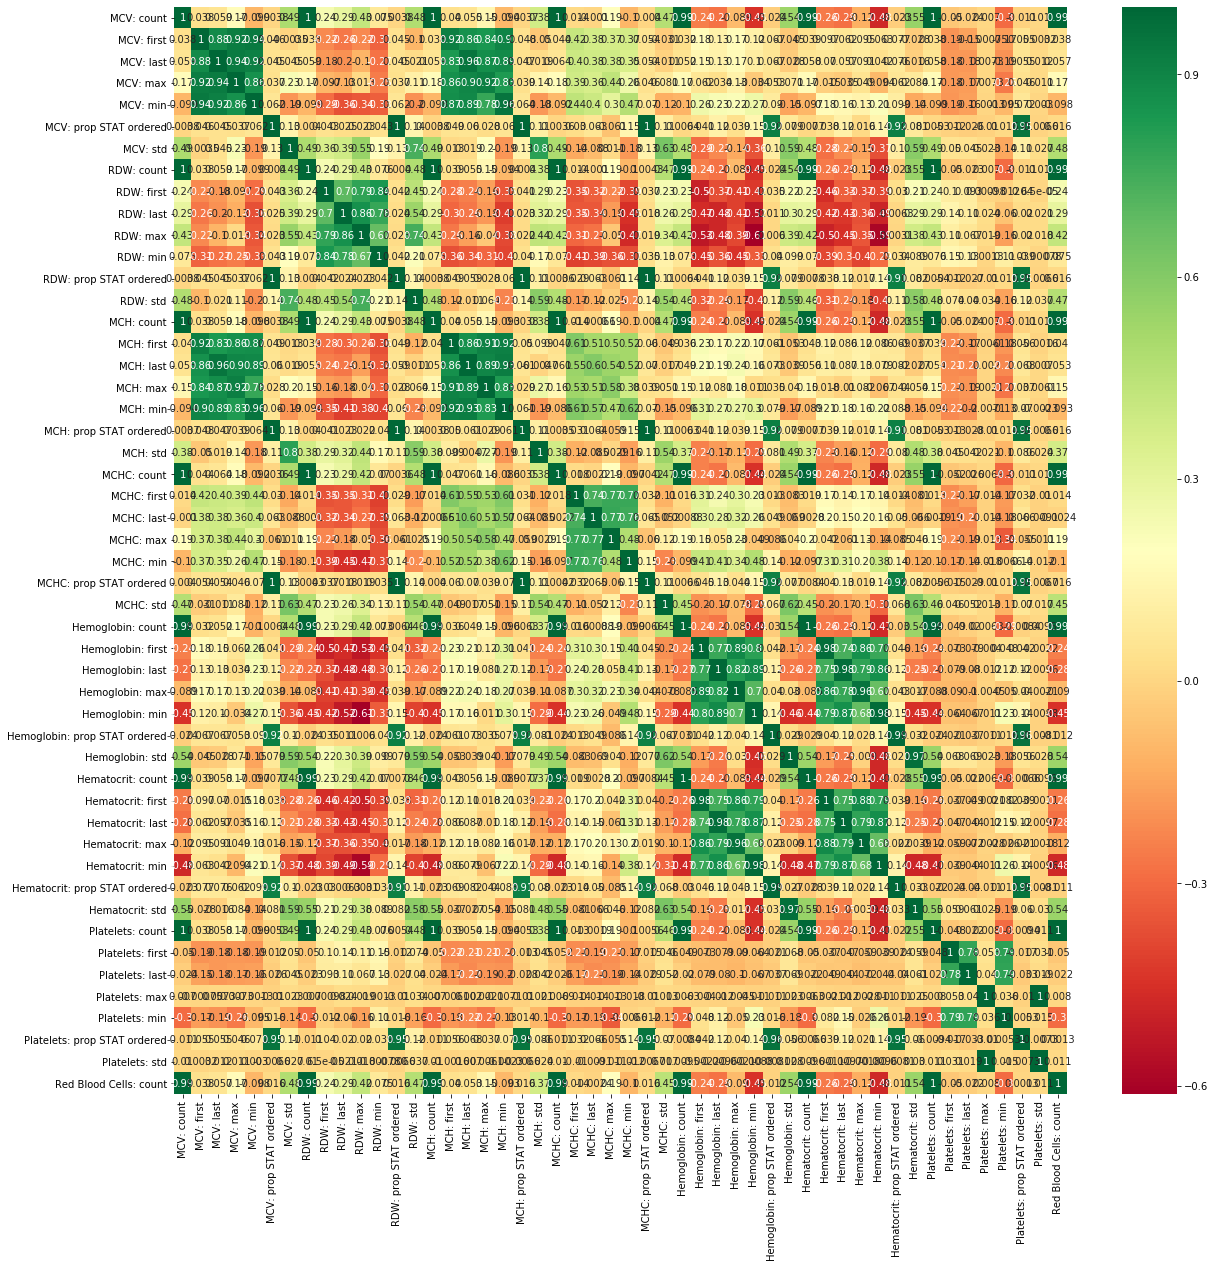

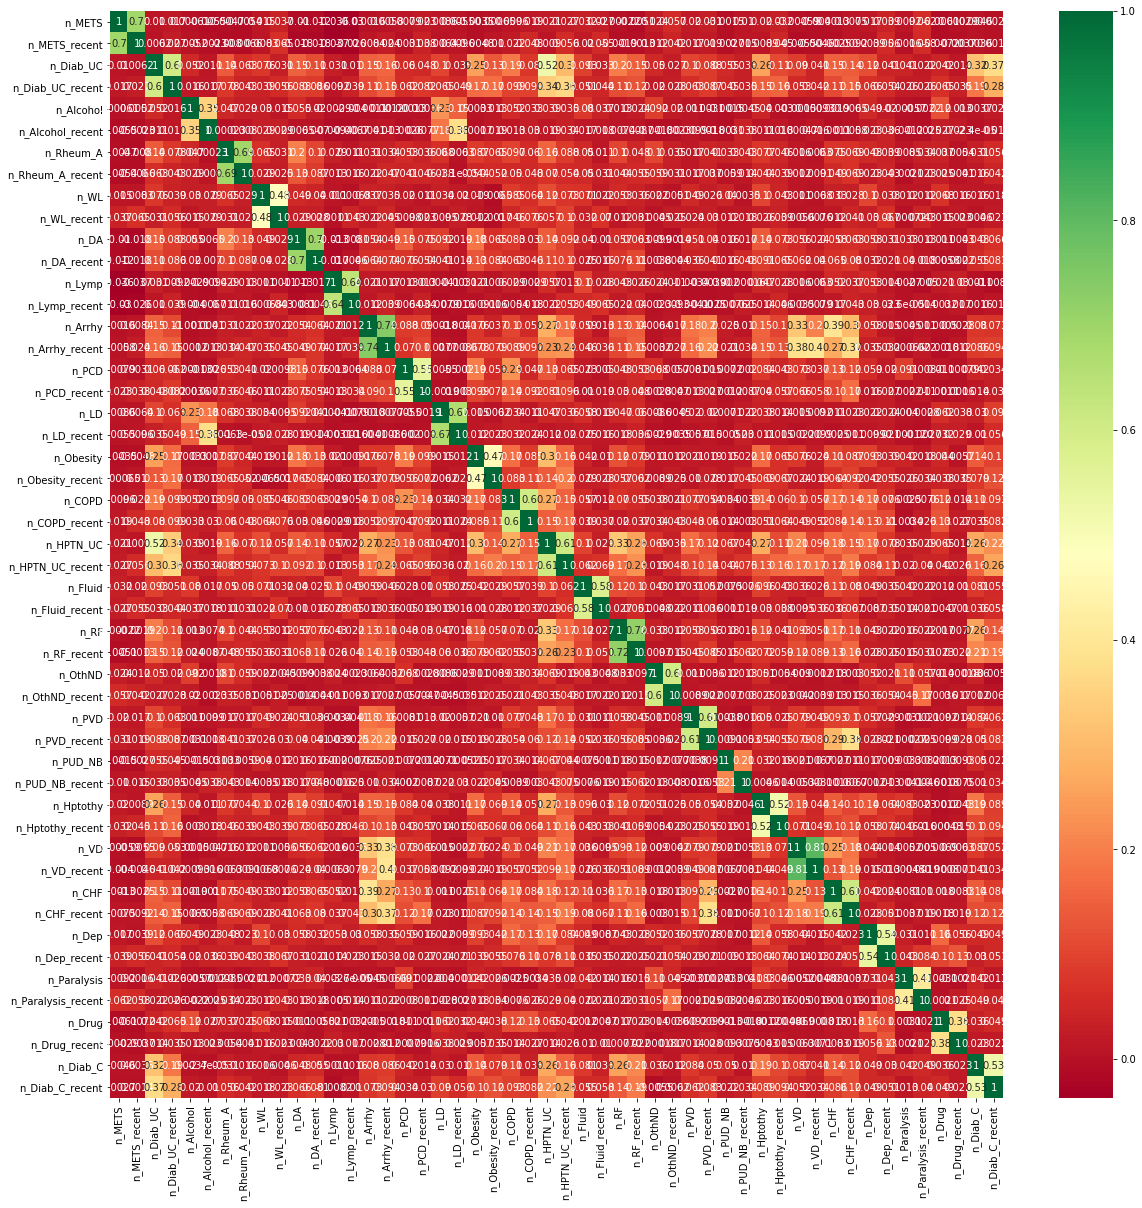

In [15]:
import seaborn as sns

plt.figure(figsize=(20,20))
g=sns.heatmap(train[num_cols[:50]].corr(),annot=True,cmap="RdYlGn")

plt.figure(figsize=(20,20))
g=sns.heatmap(train[dx_cols[:50]].corr(),annot=True,cmap="RdYlGn")

In [16]:
# drop correlated features, retain a map of redundancy
CORRELATION_THRESHOLD = 0.95

grouped = []
grouped_dict = {}
cor_map = train[in_vars].corr()
for var in cor_map.index:
    if var not in grouped:
        cor_vec = cor_map.loc[var,:]
        idb_cor =  cor_vec > CORRELATION_THRESHOLD
        collected = list(cor_vec[idb_cor].index)
        collected = [c for c in collected if c != var]
        grouped.extend(collected)
        grouped_dict.update({var: collected})

For each set of highly correlated features, one is selected as the representative and the rest are dropped. The `grouped_dict` object stores the names of features which are retained as group representatives along with a list of the original features which they represent.

The count features make a lot of sense in particular as they are often labs from a panel, hence would all have been drawn the same number of times.

In [17]:
grouped_dict = {k:v for k,v in grouped_dict.items() if len(v)>0}
grouped_dict

{'MCV: count': ['RDW: count',
  'MCH: count',
  'MCHC: count',
  'Hemoglobin: count',
  'Hematocrit: count',
  'Platelets: count',
  'Red Blood Cells: count',
  'Creatinine: count',
  'White Blood Cells: count',
  'Sodium: count',
  'Urea Nitrogen: count',
  'Chloride: count',
  'Potassium: count',
  'Anion Gap: count',
  'Carbon Dioxide: count',
  'Glucose: count',
  'Calcium: count'],
 'MCV: last': ['MCH: last'],
 'MCV: min': ['MCH: min'],
 'MCV: prop STAT ordered': ['RDW: prop STAT ordered',
  'MCH: prop STAT ordered',
  'MCHC: prop STAT ordered',
  'Platelets: prop STAT ordered'],
 'Hemoglobin: first': ['Hematocrit: first'],
 'Hemoglobin: last': ['Hematocrit: last'],
 'Hemoglobin: max': ['Hematocrit: max'],
 'Hemoglobin: min': ['Hematocrit: min'],
 'Hemoglobin: prop STAT ordered': ['Hematocrit: prop STAT ordered',
  'Platelets: prop STAT ordered'],
 'Hemoglobin: std': ['Hematocrit: std'],
 'Platelets: max': ['Platelets: std'],
 'Red Blood Cells: max': ['Red Blood Cells: std'],
 'Re

In [18]:
# Drop those variables that have been grouped into a single representative
in_vars = [v for v in in_vars if v not in grouped]

# Number of features remaining
len(in_vars)

590

### Mutual information criteria

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecation

In [20]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)

In [21]:
fit = bestfeatures.fit(train[in_vars], train['label'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train[in_vars].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['var','score']
print(featureScores.nlargest(10,'score'))

                           var     score
220              Albumin: last  0.021383
222               Albumin: min  0.020670
76                    MCH: std  0.019989
160                   AST: std  0.019219
71                    RDW: max  0.018481
169  Alkaline Phosphatase: max  0.018480
73                    RDW: std  0.018273
111                Sodium: min  0.017735
133             Anion Gap: std  0.017553
196         % Lymphocytes: min  0.017310


In [22]:
#drop those with no mutual information
zero_mutual_info_vars = featureScores[featureScores['score'] == 0.0]['var'].values
zero_mutual_info_vars

array(['n_Diab_UC', 'n_DA_recent', 'n_Obesity_recent', 'n_RF',
       'n_VD_recent', 'n_Diab_C_recent', 'n_BLA_recent', 'n_HIV_recent',
       'n_HPTN_C_recent', '# Atypical Lymphocytes: last',
       '% Lymph Variants: first', '% Lymph Variants: max',
       '# Basophils Manual: min',
       'LACTATE DEHYDROGENASE: prop STAT ordered',
       'LACTIC ACID: prop STAT ordered',
       'IMMUNOGLOBULIN G: prop STAT ordered', 'IMMUNOGLOBULIN G: std',
       'IMMUNOGLOBULIN M: std', 'IMMUNOGLOBULINS A: std',
       'Albumin Fraction: prop STAT ordered', 'RETICULOCYTE COUNT: count',
       'RETICULOCYTE COUNT: prop STAT ordered',
       'Total Cholesterol: first', 'Total Cholesterol: prop STAT ordered',
       'Total Cholesterol: std', 'Alpha1-Globulin Frac: first',
       'Alpha1-Globulin Frac: last', 'Alpha1-Globulin Frac: min',
       'Alpha1-Globulin Frac: std',
       'TACROLIMUS (FK506): prop STAT ordered',
       'SPECIALTY >>> Hematology/Oncology'], dtype=object)

In [23]:
in_vars = [v for v in in_vars if v not in zero_mutual_info_vars]
len(in_vars)

559

In [24]:
def cumulative_importance_plot(importances, top_n=100):
    imp = importances.sort_values('importance',ascending=False).copy()
    imp.index = range(imp.shape[0])
    imp['cumulative_prop'] = imp['importance'].cumsum()/imp['importance'].sum()
    
    if top_n is None:
        top_n = imp.shape[0]
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    
    ax.bar(range(min(top_n,imp.shape[0])), imp['importance'].head(top_n).values)
    ax.set_xticks(range(top_n))
    ax.set_ylabel('Importance')
    
    ax2 = ax.twinx()
    ax2.plot(imp['cumulative_prop'].head(top_n),color='red')
    ax2.set_xticks(range(top_n))
    ax2.set_ylabel('Cummulative Proportional\nImportance')
    
    ax.set_xticklabels(imp['var'].head(top_n),rotation=90)
    plt.show()
    return imp

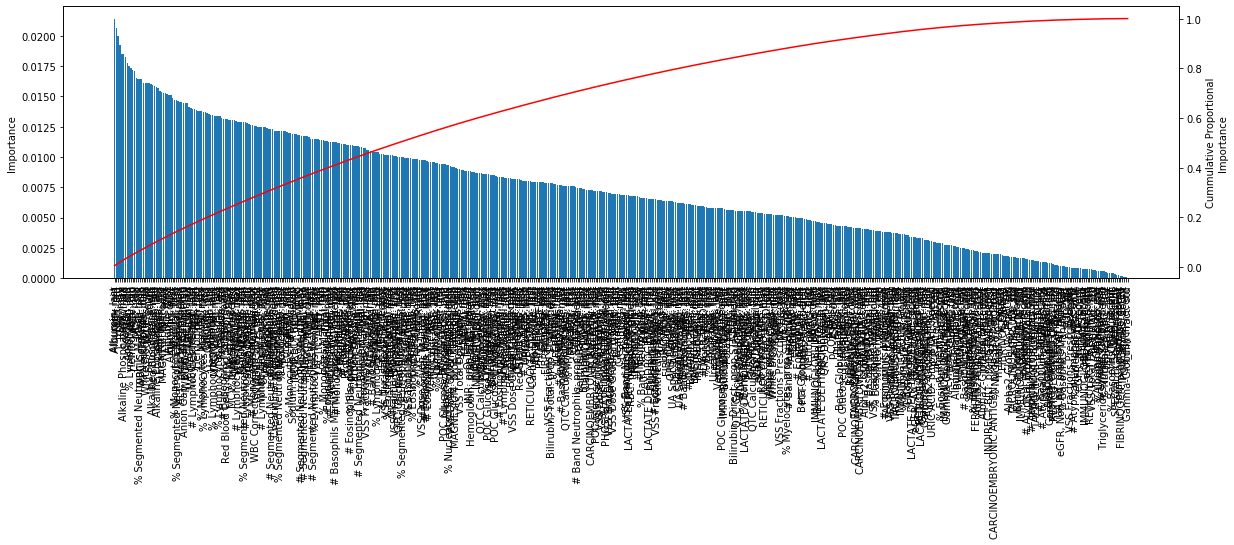

In [25]:
featureScores_as_importance = featureScores[featureScores['score'] != 0.0].copy()
featureScores_as_importance.columns = ['var','importance']
imp = cumulative_importance_plot(featureScores_as_importance, len(in_vars))

In [26]:
imp.head()

var  importance  cumulative_prop
0  Albumin: last    0.021383         0.005190
1   Albumin: min    0.020670         0.010208
2       MCH: std    0.019989         0.015060
3       AST: std    0.019219         0.019724
4       RDW: max    0.018481         0.024210

In [27]:
imp.tail()

var  importance  cumulative_prop
554       Total Cholesterol: count    0.000172         0.999926
555  FIBRINOGEN: prop STAT ordered    0.000129         0.999958
556           Triglycerides: count    0.000091         0.999980
557                 n_Psych_recent    0.000061         0.999995
558      Gamma-Globulin Fract: std    0.000022         1.000000

# Final Features Selected

In [28]:
len(in_vars)

559

In [29]:
in_vars

['n_METS',
 'n_METS_recent',
 'n_Diab_UC_recent',
 'n_Alcohol',
 'n_Alcohol_recent',
 'n_Rheum_A',
 'n_Rheum_A_recent',
 'n_WL',
 'n_WL_recent',
 'n_DA',
 'n_Lymp',
 'n_Lymp_recent',
 'n_Arrhy',
 'n_Arrhy_recent',
 'n_PCD',
 'n_PCD_recent',
 'n_LD',
 'n_LD_recent',
 'n_Obesity',
 'n_COPD',
 'n_COPD_recent',
 'n_HPTN_UC',
 'n_HPTN_UC_recent',
 'n_Fluid',
 'n_Fluid_recent',
 'n_RF_recent',
 'n_OthND',
 'n_OthND_recent',
 'n_PVD',
 'n_PVD_recent',
 'n_PUD_NB',
 'n_PUD_NB_recent',
 'n_Hptothy',
 'n_Hptothy_recent',
 'n_VD',
 'n_CHF',
 'n_CHF_recent',
 'n_Dep',
 'n_Dep_recent',
 'n_Paralysis',
 'n_Paralysis_recent',
 'n_Drug',
 'n_Drug_recent',
 'n_Diab_C',
 'n_Coag',
 'n_Coag_recent',
 'n_BLA',
 'n_Tumor',
 'n_Tumor_recent',
 'n_HIV',
 'n_HPTN_C',
 'n_Psych',
 'n_Psych_recent',
 'MCV: count',
 'MCV: first',
 'MCV: last',
 'MCV: max',
 'MCV: min',
 'MCV: prop STAT ordered',
 'MCV: std',
 'RDW: first',
 'RDW: last',
 'RDW: max',
 'RDW: min',
 'RDW: std',
 'MCH: first',
 'MCH: max',
 'MCH: st

In [30]:
with open('../models/in_vars.p','wb') as f:
    pickle.dump(in_vars, f, pickle.HIGHEST_PROTOCOL)

At this point, the selected features are used to build the models using random grid search for hyperparameter optimization.

### Build & Run

Replace `/data/eol/eol-onc/` with the path to this project and run the following:

```bash
docker build -t eol .
docker run -d --rm -it -v /data/eol/eol-onc/:/data eol /bin/bash
```

### Training

Connect to the running container by finding the container name with `docker ps`

```bash
docker exec -it <container name> /bin/bash
```

In the container, spin up training jobs with:
```bash
cd /data
source activate eol_paper
nohup python3 EoL_model_ONC_v1_2.py -f data/OutpatientONC_v1_1_enc_data_features.csv --n-iter 500 --k-cv 5 -m rf > rf_gs.out &
disown %1

nohup python3 EoL_model_ONC_v1_2.py -f data/OutpatientONC_v1_1_enc_data_features.csv --n-iter 500 --k-cv 5 -m gb > gb_gs.out &
disown %1
```

Download the resulting model files for evaluation.

# Evaluation

In [31]:
with open('../models/in_vars.p','rb') as f:
    in_vars = pickle.load(f)

In [32]:
from sklearn import metrics

def binary_cv_metrics(y, preds, m):
    ACC = metrics.accuracy_score(y,preds)
    cm = metrics.confusion_matrix(y,preds)
    if y.mean() == 0:
        cm = np.array([[np.logical_not(preds).sum(),preds.sum()],[0,0]])
        ACC = np.logical_not(preds).mean()
    elif y.mean() == 1:
        cm = np.array([[0,0],[np.logical_not(preds).sum(),preds.sum()]])
        ACC = preds.mean()
        
    m['confusion_matrix'] = cm
    m['Accuracy'] = ACC
    m['base rate'] = y.mean()
    m['n'] = cm.sum()
    m['F1 score'] = metrics.f1_score(y,preds)
    m['FPR'] = cm[0,1]/(cm[0,:].sum()*1.0)
    m['FNR'] = cm[1,0]/(cm[1,:].sum()*1.0)
    m['Alert Rate'] = cm[:,1].sum()*1.0 / cm.sum()
    m['Specificity (TNR)'] = cm[0,0]/(cm[0,:].sum()*1.0)
    m['Sensitivity (TPR, Recall)'] = cm[1,1]/(cm[1,:].sum()*1.0)
    m['PPV (Precision)'] = cm[1,1]/(cm[:,1].sum()*1.0)
    m['NPV'] = cm[0,0]/(cm[:,0].sum()*1.0)

def cv_metrics(y,probas,m,threshold=0.5):
    '''Collect performance metrics'''
    preds = probas >= threshold

    fpr, tpr, thresholds = metrics.roc_curve(y, probas)
    try:
        AUC = metrics.auc(fpr, tpr)
        m['AUC'] = AUC
    except:
        m['AUC'] = np.nan
        
    binary_cv_metrics(y, preds, m)

In [33]:
def plot_perf(clf, in_vars, test,label_name='label',plt_cal=True, logistic=False):  
    if logistic:
        test['Pred'] = result.predict(test[in_vars])
    else:
        test['Pred'] = clf.predict_proba(test[in_vars])[:,1]

    preds = test['Pred'].values
    preds = np.array([preds,preds]).T
    ms = []
    threshes = np.linspace(0,test['Pred'].max(),100)
    for thresh in threshes:
        m = {}
        criteria = test['Pred'] > thresh
        binary_cv_metrics(test[label_name],criteria ,m)
        m['threshold'] = thresh
        ms.append(m)
    ms_df = pd.DataFrame(ms)

    fig, ax = plt.subplots(2,1,figsize=(8,8))
    for metric in ['F1 score','NPV','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']:
        ax[0].plot(threshes,ms_df[metric],'-',label=metric)
    ax[0].legend(loc=0)

    ps_analysis_utils.plt_auc(preds,test[label_name],ax=ax[1])
    
    if plt_cal:
        ps_analysis_utils.plot_calibration_curve_error_bars(test[label_name],test['Pred'],n_bins=10)
    
    plt.show()
    importances = None
    if not logistic:
        importances = pd.DataFrame([{'importance':m,'var':in_vars[e]} for e,m in enumerate(clf.feature_importances_)])
        importances = importances.sort_values('importance',ascending=False)
    return importances, ms_df

## Random Forest

In [34]:
with open('../models/rf_random_search.p','rb') as f:
    rf_random = pickle.load(f)

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._grad

In [35]:
rf_random

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [36]:
clf_rf = rf_random.best_estimator_

In [37]:
clf_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=55, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [38]:
clf_rf.oob_score_

0.9617062530295686

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/eol_pape

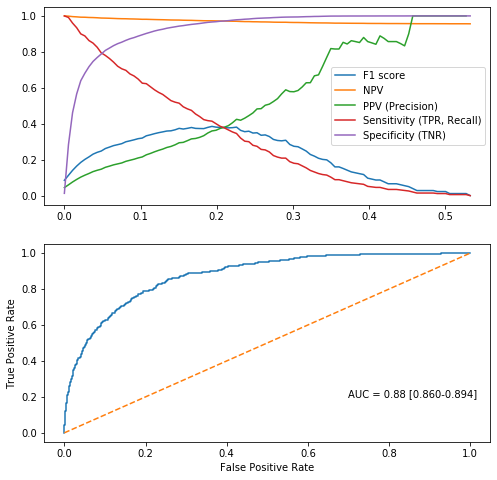

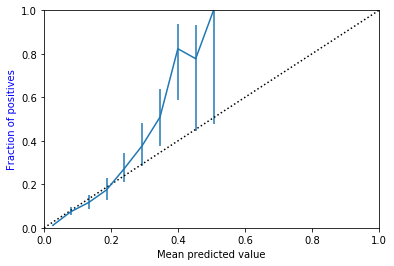

importance                         var
211    0.014236               Albumin: last
1      0.012834               n_METS_recent
213    0.012776                Albumin: min
159    0.011911  Alkaline Phosphatase: last
557    0.011550                     PAT_AGE
48     0.011300              n_Tumor_recent
160    0.010521   Alkaline Phosphatase: max
47     0.010061                     n_Tumor
0      0.009438                      n_METS
185    0.008932         % Lymphocytes: last
187    0.008917          % Lymphocytes: min
62     0.008273                    RDW: max
205    0.007519         % Neutrophils: last
162    0.006942   Alkaline Phosphatase: std
53     0.006639                  MCV: count
226    0.006372            MAGNESIUM: count
148    0.006344                   AST: last
64     0.006123                    RDW: std
206    0.006005          % Neutrophils: max
59     0.005952                    MCV: std

In [39]:
importances, ms_df_rf = plot_perf(clf_rf, in_vars, test)
importances.sort_values('importance',ascending=False).head(20)

In [40]:
test.head()

APPT_TIME           BIRTH_DATE        CSN DEATH_DATE  \
0  2016-05-18 11:15:00  1954-07-17 00:00:00  145963403        NaT   
4  2016-03-22 15:30:00  1954-05-19 00:00:00  143108719        NaT   
8  2016-04-26 12:00:00  1970-02-25 00:00:00  145290207        NaT   
13 2016-03-02 08:00:00  1966-07-24 00:00:00  141471196        NaT   
17 2016-02-10 10:15:00  1985-09-20 00:00:00  141448333        NaT   

                 DEPARTMENT_NAME        EMPI                    EXTERNAL_NAME  \
0      PENN HEM ONC WEST CHESTER  8444980973        PENN HEM ONC WEST CHESTER   
4      HEM ONC CENTER PERELMAN 3  1000975908  Division of Hematology/Oncology   
8      HEM ONC CENTER PERELMAN 3  8440627206  Division of Hematology/Oncology   
13              MSG HEM/ONC PPMC  1003616511                     PPMC Hem Onc   
17  GYNECOLOGY ONCOLOGY PERELMAN  1003915699      Division of OB/Gyn Oncology   

      PAT_ID                 PROVIDER_NAME           PROV_TYPE  SEX_C  \
0   Z2173887             Maureen R. Hewitt           Physician    1.0   
4    5094644             Amy Sanders Clark           Physician    1.0   
8   Z1741310               Loreli A Graham  Nurse Practitioner    1.0   
13   Z641533  Elizabeth A. Prechtel-Dunphy  Nurse Practitioner    2.0   
17  52524618                 Janos L Tanyi           Physician    1.0   

              SPECIALTY  MCV: count  MCV: first  MCV: last  MCV: max  \
0   Hematology/Oncology        16.0        94.0       92.0      96.0   
4              Oncology         0.0        91.0       91.0      93.0   
8              Oncology         5.0        91.0       92.0      92.0   
13  Hematology/Oncology         5.0        92.0       90.0      92.0   
17             Oncology         0.0        91.0       91.0      93.0   

    MCV: min  MCV: prop STAT ordered  MCV: std  RDW: count  RDW: first  \
0       92.0                  0.0625  1.376893        16.0        20.1   
4       89.0                  0.0000  0.000000         0.0        14.7   
8       90.0                  1.0000  0.836660         5.0        12.8   
13      88.0                  1.0000  1.483240         5.0        12.6   
17      89.0                  0.0000  0.000000         0.0        14.7   

    RDW: last  RDW: max  RDW: min  RDW: prop STAT ordered  RDW: std  \
0        13.0      20.1      13.0                  0.0625  2.648010   
4        15.3      16.3      14.1                  0.0000  0.000000   
8        13.3      13.3      12.6                  1.0000  0.258844   
13       14.3      14.3      12.6                  1.0000  0.687750   
17       15.3      16.3      14.1                  0.0000  0.000000   

    MCH: count  MCH: first  MCH: last  MCH: max  MCH: min  \
0         16.0        30.0       29.0      32.0      29.0   
4          0.0        30.0       30.0      31.0      29.4   
8          5.0        30.0       30.0      30.0      30.0   
13         5.0        29.0       29.0      29.0      29.0   
17         0.0        30.0       30.0      31.0      29.4   

    MCH: prop STAT ordered  MCH: std  MCHC: count  MCHC: first  MCHC: last  \
0                   0.0625   0.80247         16.0         32.0        32.0   
4                   0.0000   0.00000          0.0         33.0        33.0   
8                   1.0000   0.00000          5.0         34.0        33.0   
13                  1.0000   0.00000          5.0         31.0        32.0   
17                  0.0000   0.00000          0.0         33.0        33.0   

    MCHC: max  MCHC: min  MCHC: prop STAT ordered  MCHC: std  \
0        33.1       31.9                   0.0625   0.493795   
4        33.9       32.0                   0.0000   0.000000   
8        34.0       33.0                   1.0000   0.547723   
13       33.0       31.0                   1.0000   0.836660   
17       33.9       32.0                   0.0000   0.000000   

    Hemoglobin: count  Hemoglobin: first  Hemoglobin: last  Hemoglobin: max  \
0                17.0                9.0              13.2         

In [41]:
test_multiple_models = test[['CSN', 'EMPI', 'PAT_ID']].copy()
test_multiple_models['pred_rf'] = test['Pred']

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/eol_pape

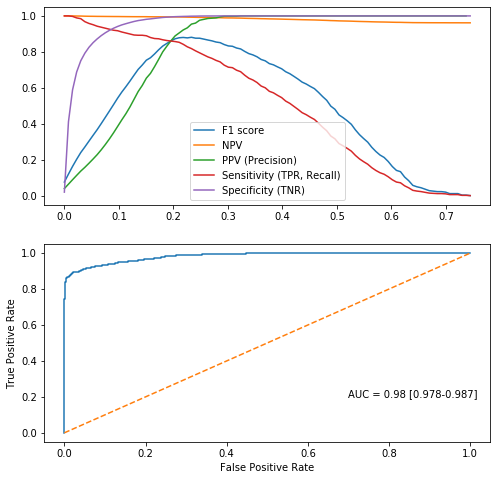

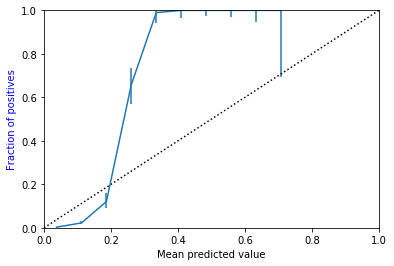

In [42]:
importances, ms_df = plot_perf(clf_rf, in_vars, train)

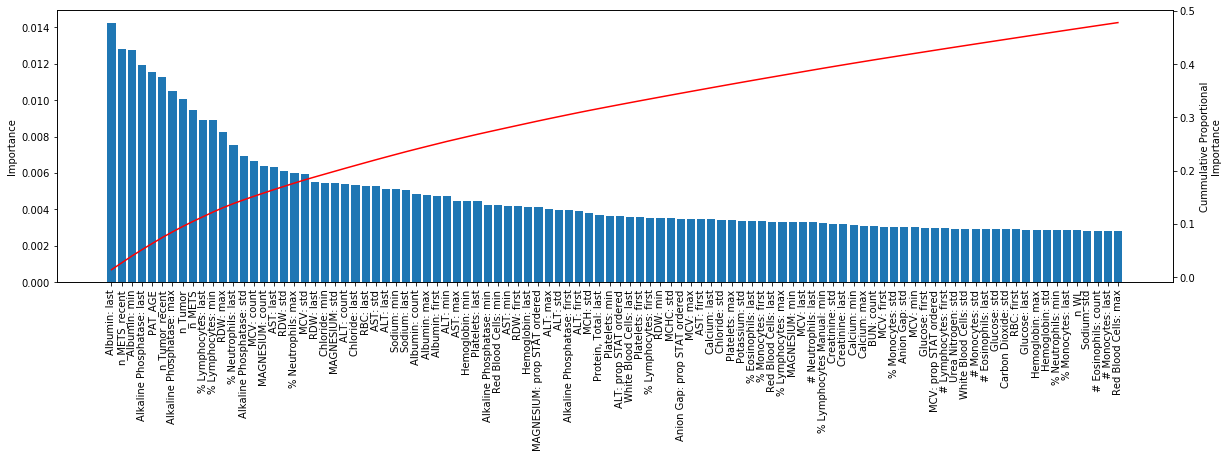

In [43]:
_ = cumulative_importance_plot(importances)

In [44]:
ms_df_rf[(ms_df_rf['threshold'] >= 0.3) & (ms_df_rf['threshold'] < 0.307)]

confusion_matrix  Accuracy  base rate     n  F1 score       FPR  \
56  [[7562, 46], [287, 63]]  0.958155   0.043981  7958   0.27451  0.006046   
57  [[7564, 44], [288, 62]]  0.958281   0.043981  7958   0.27193  0.005783   

         FNR  Alert Rate  Specificity (TNR)  Sensitivity (TPR, Recall)  \
56  0.820000    0.013697           0.993954                   0.180000   
57  0.822857    0.013320           0.994217                   0.177143   

    PPV (Precision)       NPV  threshold  
56         0.577982  0.963435   0.301344  
57         0.584906  0.963321   0.306725

# Gradient Boosting

In [45]:
with open('../models/gb_random_search.p','rb') as f:
    gb_random = pickle.load(f)
clf_gb = gb_random.best_estimator_
clf_gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=890,
                           n_iter_no_change=5, presort='auto', random_state=42,
                           subsample=1.0, tol=0.0001, validation_fraction=0.1,
                           verbose=1, warm_start=False)

In [46]:
gb_random.param_distributions

{'max_features': ['auto', 'sqrt'],
 'max_depth': [5,
  10,
  15,
  20,
  25,
  30,
  35,
  40,
  45,
  50,
  55,
  60,
  65,
  70,
  75,
  80,
  85,
  90,
  95,
  100,
  None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000],
 'subsample': [0.5, 0.8, 1.0],
 'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
        0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
 'loss': ['deviance', 'exponential']}

In [47]:
# with open('../models/gb_random_search_noearlystopping.p','rb') as f:
#     gb_random = pickle.load(f)
# clf_gb = gb_random.best_estimator_
# clf_gb

In [48]:
#gb_random.cv_results_['split1_test_score']

In [49]:
gb_random.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_subsample', 'param_n_estimators', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_max_depth', 'param_loss', 'param_learning_rate', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/neelay/Projects/eol-onc/notebooks/ps_analysis_utils.py:32: RuntimeWarning: invalid value enco

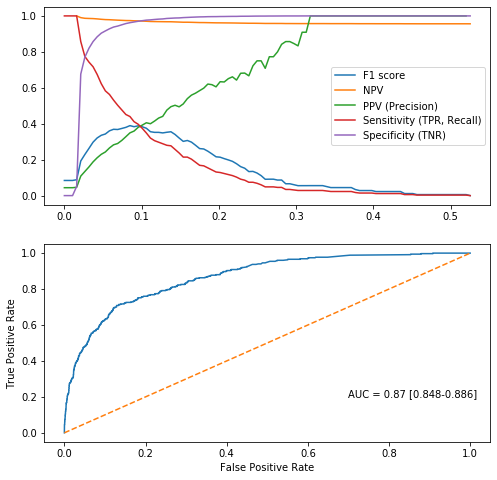

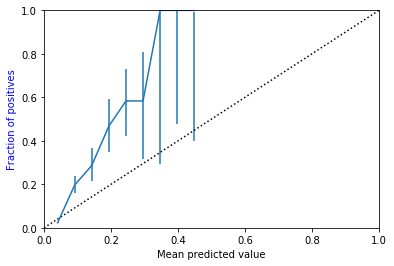

importance                         var
211    0.018748               Albumin: last
48     0.016173              n_Tumor_recent
0      0.014638                      n_METS
1      0.013776               n_METS_recent
159    0.013471  Alkaline Phosphatase: last
185    0.012574         % Lymphocytes: last
205    0.011526         % Neutrophils: last
213    0.010924                Albumin: min
160    0.008738   Alkaline Phosphatase: max
187    0.008206          % Lymphocytes: min
61     0.007796                   RDW: last
557    0.007749                     PAT_AGE
59     0.007273                    MCV: std
206    0.007073          % Neutrophils: max
47     0.006922                     n_Tumor
212    0.006764                Albumin: max
317    0.006637   % Lymphocytes Manual: min
102    0.006413                 Sodium: min
140    0.006337                  ALT: count
162    0.005941   Alkaline Phosphatase: std

In [50]:
importances, ms_df_gb = plot_perf(clf_gb, in_vars, test)
importances.sort_values('importance',ascending=False).head(20)

In [51]:
test_multiple_models['pred_gb'] = test['Pred']

In [52]:
test_multiple_models.head()

CSN        EMPI    PAT_ID   pred_rf   pred_gb
0   145963403  8444980973  Z2173887  0.149831  0.050373
4   143108719  1000975908   5094644  0.007915  0.017296
8   145290207  8440627206  Z1741310  0.005946  0.019073
13  141471196  1003616511   Z641533  0.015094  0.026936
17  141448333  1003915699  52524618  0.001390  0.017125

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


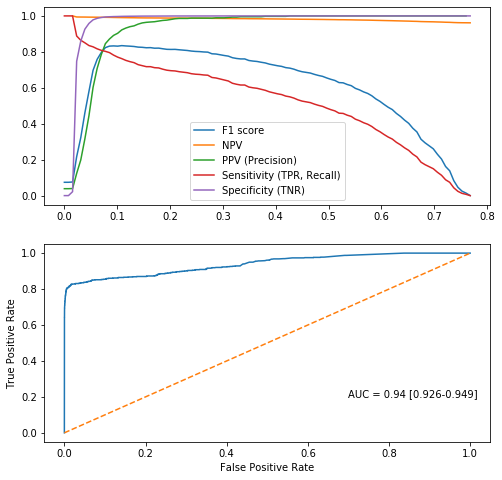

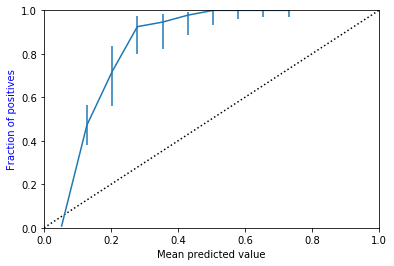

In [53]:
importances, ms_df = plot_perf(clf_gb, in_vars, train)

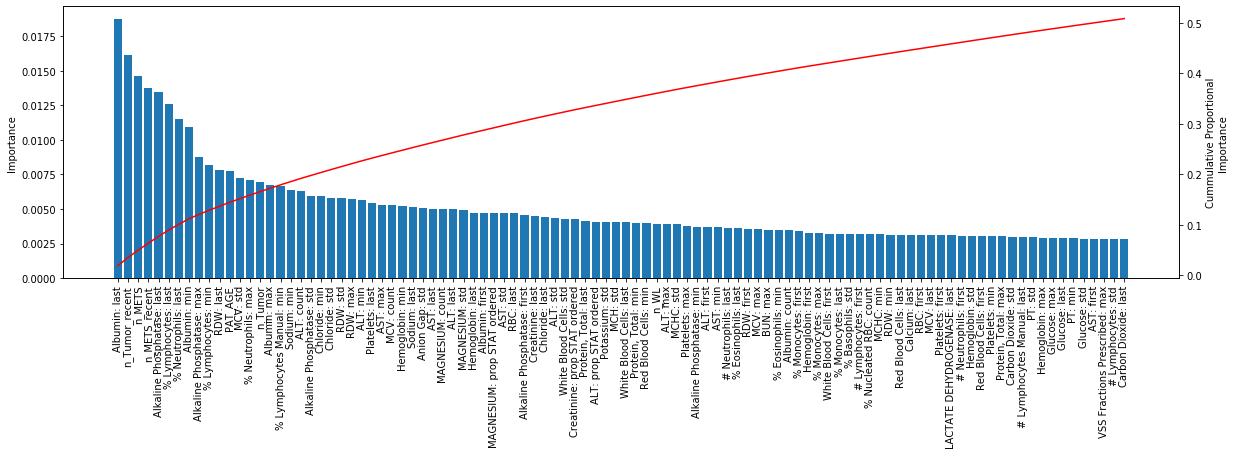

In [54]:
_ = cumulative_importance_plot(importances)

In [55]:
imp = importances.sort_values('importance',ascending=False)
imp[imp['importance'] > 0.0].shape

(550, 2)

In [56]:
ms_df_gb[(ms_df_gb['threshold'] >= 0.3) & (ms_df_gb['threshold'] < 0.307)]

confusion_matrix  Accuracy  base rate     n  F1 score       FPR  \
57  [[7606, 2], [340, 10]]  0.957024   0.043981  7958  0.055249  0.000263   

         FNR  Alert Rate  Specificity (TNR)  Sensitivity (TPR, Recall)  \
57  0.971429    0.001508           0.999737                   0.028571   

    PPV (Precision)       NPV  threshold  
57         0.833333  0.957211   0.302393

In [57]:
# fig, ax = plt.subplots(1,1)
# ax.hist(test[test['label'] == 1]['Pred'].values,bins=50,alpha=0.2,normed=True)
# ax.hist(test[test['label'] == 0]['Pred'].values,bins=50,alpha=0.2,normed=True);
# plt.show()

In [58]:
#test['PROVIDER_NAME'].value_counts()

In [59]:
#test.sort('Pred').tail(20)

subpopulation analysis for  SPECIALTY : ['Hematology/Oncology' 'Oncology']


/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


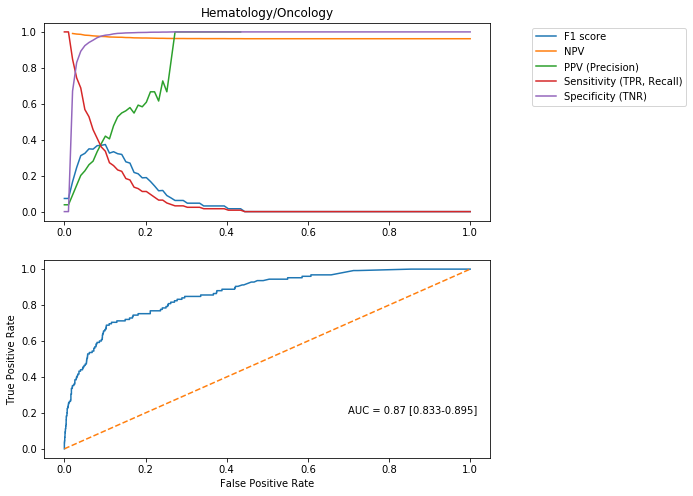

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


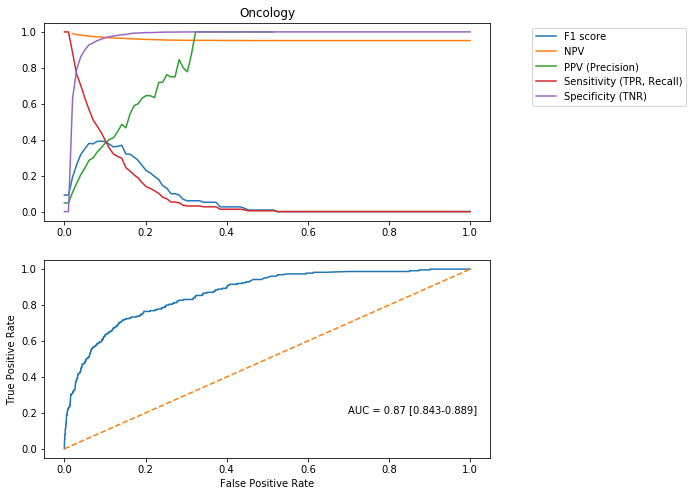

AUC       confusion_matrix  Accuracy  base rate  \
Hematology/Oncology  0.865585  [[3170, 0], [122, 3]]  0.962974  0.0379363   
Oncology             0.866996  [[4436, 2], [218, 7]]   0.95282  0.0482522   

                        n   F1 score          FPR       FNR  Alert Rate  \
Hematology/Oncology  3295   0.046875            0     0.976  0.00091047   
Oncology             4663  0.0598291  0.000450653  0.968889  0.00193009   

                    Specificity (TNR) Sensitivity (TPR, Recall)  \
Hematology/Oncology                 1                     0.024   
Oncology                     0.999549                 0.0311111   

                    PPV (Precision)       NPV threshold  
Hematology/Oncology               1   0.96294   0.30303  
Oncology                   0.777778  0.953159   0.30303

In [60]:
def plt_performance(df,plot_output=True,plt_title=''):
    preds = df['Pred'].values
    preds = np.array([preds,preds]).T
    ms = []
    threshes = np.linspace(0,1,100)
    for thresh in threshes:
        m = {}
        #criteria = df['Pred'] > thresh
        cv_metrics(df[label_name],df['Pred'],m,thresh)
        #m[dx_class] = n
        m.update({'threshold':thresh})
        ms.append(m)
    ms_df = pd.DataFrame(ms)
    
    if plot_output:
        fig, ax = plt.subplots(2,1,figsize=(8,8))
        for metric in ['F1 score','NPV','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']:
            ax[0].plot(threshes,ms_df[metric],'-',label=metric)
        ax[0].legend(bbox_to_anchor=(1.45, 1.0))
        ax[0].set_title(plt_title)
        try:
            ps_analysis_utils.plt_auc(preds,df[label_name],ax=ax[1])
        except:
            pass
        plt.show()
    return ms_df


def run_categorical_subpop(df,category_var,plot_output=True,thresh=0.5):
    m_list = []
    categories = df[category_var].unique()
    print('subpopulation analysis for ',category_var, ':',categories)
    for category in categories:
        idb = df[category_var] == category
        subpop = df[idb]
        if subpop[label_name].sum() == 0 or idb.sum() < 5:
            ms_df = plt_performance(subpop,False,plt_title=category)
            #m = pd.DataFrame([{'n':idb.sum(),'base rate':0.0}])
        else:
            ms_df = plt_performance(subpop,plot_output,plt_title=category)
        m = pd.DataFrame(ms_df.iloc[np.argmin(np.abs(ms_df['threshold'] - thresh))]).T
        m.index = [category]
        m_list.append(m)
    return pd.concat(m_list)


def run_numerical_subpop(df,category_var,plot_output=True,thresh=0.5):
    m_list = []
    categories = []
    n_tiles = 10
    n_tile = np.linspace(0,1,n_tiles)
    n_tile = list(df[category_var].quantile(n_tile))
    for t in range(n_tiles-1):
        idb = (df[category_var] > n_tile[t]) & (df[category_var] <= n_tile[t+1])
        categories.append({'range': "%0.0f-%0.0f"%(n_tile[t],n_tile[t+1]),
                          'idb': idb})
    
    print('subpopulation analysis for ',category_var, ':',[c['range'] for c in categories])
    for category in categories:
        idb = category['idb']
        subpop = df[idb]
        if subpop[label_name].sum() == 0 or idb.sum() < 5:
            m = pd.DataFrame([{'n':idb.sum(),'base rate':0.0}])
        else:
            ms_df = plt_performance(subpop,plot_output,plt_title=category['range'])
            m = pd.DataFrame(ms_df.iloc[np.argmin(np.abs(ms_df['threshold'] - thresh))]).T
        m.index = [category['range']]
        m_list.append(m)
    return pd.concat(m_list)

#sp_age = run_numerical_subpop(test,'SPECIALTY',plot_output=False,thresh=0.3)
sp_specialty = run_categorical_subpop(test,'SPECIALTY',thresh=0.3)
sp_specialty

In [61]:
sp_specialty.T

Hematology/Oncology               Oncology
AUC                                     0.865585               0.866996
confusion_matrix           [[3170, 0], [122, 3]]  [[4436, 2], [218, 7]]
Accuracy                                0.962974                0.95282
base rate                              0.0379363              0.0482522
n                                           3295                   4663
F1 score                                0.046875              0.0598291
FPR                                            0            0.000450653
FNR                                        0.976               0.968889
Alert Rate                            0.00091047             0.00193009
Specificity (TNR)                              1               0.999549
Sensitivity (TPR, Recall)                  0.024              0.0311111
PPV (Precision)                                1               0.777778
NPV                                      0.96294               0.953159
threshold                                0.30303                0.30303

In [62]:
def buffer_ylim(ax,buff_prop = 0.2):
    ylim = ax.get_ylim()
    limrange = ylim[1] - ylim[0]
    buff = limrange * buff_prop
    ax.set_ylim([ylim[0]-buff,ylim[1]+buff])

def buffer_xlim(ax,buff_prop = 0.2):
    xlim = ax.get_xlim()
    limrange = xlim[1] - xlim[0]
    buff = limrange * buff_prop
    ax.set_xlim([xlim[0]-buff,xlim[1]+buff])


def plt_subpop_perf(df,title='Subgroup Performance',xlabel=''):
    first_plot_items = ['AUC','Accuracy','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']
    second_plot_items = ['base rate']
    third_plot_items = ['n']
    fig, axx = plt.subplots(3,1, sharex=True,figsize=(8,8))
    ax = axx[0]
    ax.set_title(title)
    for fp_item in first_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(bbox_to_anchor=(1.6, 1.0))
    ax.grid()
    buffer_ylim(ax,0.1)
    
    ax = axx[1]
    for fp_item in second_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(bbox_to_anchor=(1.35, 1.0))
    ax.grid()
    buffer_ylim(ax,0.1)
    
    ax = axx[2]
    for fp_item in third_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
    ax.set_xticks(range(df.shape[0]))
    ax.set_xticklabels(df.index,rotation=45,horizontalalignment='right')
    ax.set_xlabel(xlabel)
    ax.grid()
    buffer_ylim(ax,0.1)
    buffer_xlim(ax,0.05)

In [63]:
# sp_age = run_numerical_subpop(test,'PAT_AGE',plot_output=False,thresh=0.3)
# plt_subpop_perf(sp_age,xlabel='PAT_AGE');

## Logistic Regression

In [64]:
enc_data['SEX_C'].dtype

dtype('float64')

In [65]:
from sklearn.linear_model import LogisticRegression

in_vars = dx_cols + num_cols + cat_cols + ['PAT_AGE','SEX_C']

in_vars = [c for c in in_vars if (': count' not in c) and \
           (': std' not in c) and \
           (': prop STAT ordered' not in c)]

### Normalize ###
no_log_list = ['PAT_AGE','SEX_C'] + num_cols
no_norm_list = []
train_norm = train.copy()
test_norm = test.copy()
norm_dict = {}
for v in in_vars:
    if v not in no_norm_list:
        if v not in no_log_list:
            norm_dict[v+' mean'] = np.log(train[v]+1).mean()
            norm_dict[v+' std'] = np.log(train[v]+1).std()
            train_norm[v] = (np.log(train[v]+1) - norm_dict[v+' mean']) / norm_dict[v+' std']
            test_norm[v] = (np.log(test[v]+1) - norm_dict[v+' mean']) / norm_dict[v+' std']
        else:
            norm_dict[v+' mean'] = train[v].mean()
            norm_dict[v+' std'] = train[v].std()
            train_norm[v] = (train[v] - norm_dict[v+' mean']) / norm_dict[v+' std']
            test_norm[v] = (test[v] - norm_dict[v+' mean']) / norm_dict[v+' std']
    else:
        train_norm[v] = train[v]*1.0
        test_norm[v] = test[v]*1.0

In [66]:
train_norm['intercept'] = 1
test_norm['intercept'] = 1

In [67]:
last_labs = [c for c in train_norm if ': last' in c]
dx_hist = [c for c in train_norm if 'n_' in c]


In [68]:
import statsmodels.api as sm
in_vars_lr = ['intercept'] +  last_labs + dx_hist + ['PAT_AGE','SEX_C']

In [69]:
## Iterative variable selectionn
last_n_vars = 0
while len(in_vars_lr) != last_n_vars:
    last_n_vars = len(in_vars_lr)
    print(last_n_vars)
    logit = sm.Logit(train_norm[label_name],train_norm[in_vars_lr])
    result = logit.fit()
    in_vars_lr = result.pvalues.index[result.pvalues < 0.1]
    
print(result.summary())

165
Optimization terminated successfully.
         Current function value: 0.117934
         Iterations 14
39
Optimization terminated successfully.
         Current function value: 0.124342
         Iterations 9
36
Optimization terminated successfully.
         Current function value: 0.124469
         Iterations 9
35
Optimization terminated successfully.
         Current function value: 0.124520
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                18567
Model:                          Logit   Df Residuals:                    18532
Method:                           MLE   Df Model:                           34
Date:                Tue, 30 Aug 2022   Pseudo R-squ.:                  0.2369
Time:                        21:31:42   Log-Likelihood:                -2312.0
converged:                       True   LL-Null:                       -3029.7
Covariance Type:         

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


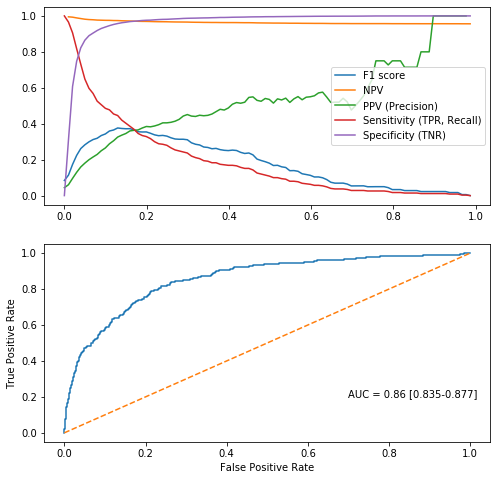

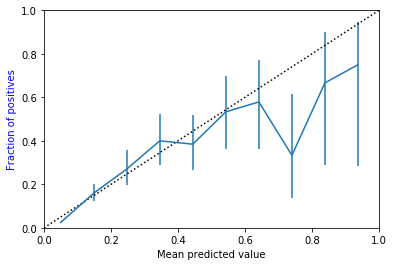

In [70]:
importances, ms_df_lr = plot_perf(result, in_vars_lr, test_norm, logistic=True)

In [71]:
test_multiple_models['pred_lr'] = test_norm['Pred']
test_multiple_models.head()

CSN        EMPI    PAT_ID   pred_rf   pred_gb   pred_lr
0   145963403  8444980973  Z2173887  0.149831  0.050373  0.012200
4   143108719  1000975908   5094644  0.007915  0.017296  0.021629
8   145290207  8440627206  Z1741310  0.005946  0.019073  0.013231
13  141471196  1003616511   Z641533  0.015094  0.026936  0.109715
17  141448333  1003915699  52524618  0.001390  0.017125  0.005357

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


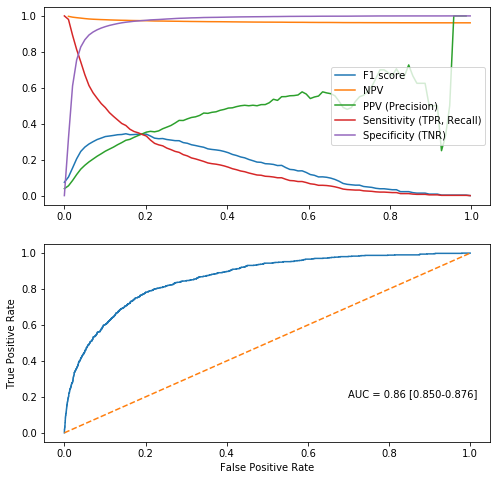

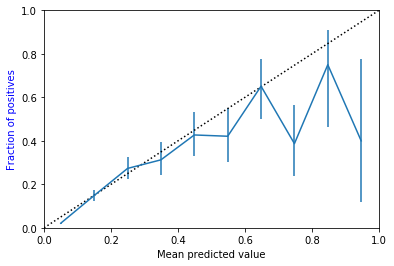

In [72]:
importances, ms_df = plot_perf(result, in_vars_lr, train_norm, logistic=True)

In [73]:
thresh = 0.3
ms_df = ms_df_lr
ms_df.iloc[np.argmin(np.abs(ms_df['threshold'] - thresh))]

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


confusion_matrix             [[7507, 101], [267, 83]]
Accuracy                                     0.953757
base rate                                   0.0439809
n                                                7958
F1 score                                     0.310861
FPR                                         0.0132755
FNR                                          0.762857
Alert Rate                                  0.0231214
Specificity (TNR)                            0.986725
Sensitivity (TPR, Recall)                    0.237143
PPV (Precision)                              0.451087
NPV                                          0.965655
threshold                                    0.299062
Name: 30, dtype: object

In [74]:
## LR "Importance" & direction
pv = pd.DataFrame(result.pvalues).sort_values(0)
pd.DataFrame(result.tvalues[pv.index])

0
intercept                  -65.132062
Albumin: last              -10.250277
n_Tumor_recent              10.022118
n_METS_recent                8.525422
PAT_AGE                      8.389282
Alkaline Phosphatase: last   5.621641
SEX_C                        5.547985
n_Tumor                     -5.059770
n_BLA                        5.026847
Red Blood Cells: last       -5.004892
RBC: last                   -4.974620
MCHC: last                  -4.719733
BUN: last                    4.508919
n_Fluid_recent               3.966320
n_OthND_recent               3.793971
n_BLA_recent                -3.612689
n_Lymp_recent                3.419417
Calcium: last                3.203568
n_Drug                       3.123582
Q-T Interval: last          -3.071578
n_PCD_recent                 2.918103
n_WL_recent                  2.818878
n_HPTN_UC_recent            -2.518616
n_Coag_recent                2.508619
n_Diab_C                     2.485651
n_Lymp                      -2.419765
FERRITIN: last               2.400047
IMMUNOGLOBULINS A: last      2.373491
n_VD_recent                 -2.113886
n_Diab_C_recent             -2.105707
Beta-Globulin Fracti: last  -2.071404
n_PVD                        2.004148
n_Obesity_recent            -1.757105
n_DA_recent                 -1.745443
Platelets: last             -1.655865

In [75]:
thresh = 0.3
perf_tables = []
ms_dfs = {'GradientBoost': ms_df_gb,
         'Random Forest': ms_df_rf,
         'Logistic Regression': ms_df_lr}
for mname, ms_df in ms_dfs.items():
    tmp = ms_df.copy()
    tmp['Model'] = mname
    loc = np.argmin(np.abs(tmp['threshold'] - thresh))
    loc = np.argmin(np.abs(tmp['Alert Rate'] - 0.02))
    perf_tables.append(pd.DataFrame(tmp.iloc[loc]))
pd.concat(perf_tables,axis=1).T.set_index('Model')

confusion_matrix  Accuracy  base rate     n  \
Model                                                                     
GradientBoost        [[7523, 85], [267, 83]]  0.955768  0.0439809  7958   
Random Forest        [[7526, 82], [265, 85]]  0.956396  0.0439809  7958   
Logistic Regression  [[7519, 89], [278, 72]]  0.953883  0.0439809  7958   

                     F1 score        FPR       FNR Alert Rate  \
Model                                                           
GradientBoost        0.320463  0.0111725  0.762857  0.0211108   
Random Forest         0.32882  0.0107781  0.757143  0.0209852   
Logistic Regression    0.2818  0.0116982  0.794286  0.0202312   

                    Specificity (TNR) Sensitivity (TPR, Recall)  \
Model                                                             
GradientBoost                0.988828                  0.237143   
Random Forest                0.989222                  0.242857   
Logistic Regression          0.988302                  0.205714   

                    PPV (Precision)       NPV threshold  
Model                                                    
GradientBoost              0.494048  0.965725  0.148544  
Random Forest              0.508982  0.965986  0.269057  
Logistic Regression        0.447205  0.964345  0.328969

In [76]:
# Test for difference among AUCs of the 3 models

# bootstrap resample, and compute the probability that model A > B, A > C, C > B, then do a correction for multiple comparisions
test_multiple_models['label'] = test['label']
test_multiple_models.head()

CSN        EMPI    PAT_ID   pred_rf   pred_gb   pred_lr  label
0   145963403  8444980973  Z2173887  0.149831  0.050373  0.012200  False
4   143108719  1000975908   5094644  0.007915  0.017296  0.021629  False
8   145290207  8440627206  Z1741310  0.005946  0.019073  0.013231  False
13  141471196  1003616511   Z641533  0.015094  0.026936  0.109715  False
17  141448333  1003915699  52524618  0.001390  0.017125  0.005357  False

In [77]:
test_multiple_models[['pred_rf','pred_gb','pred_lr','label']].to_csv('../data/test_score_multiple_models.csv', index=False)

In [78]:
DAYS_IN_NS = 8.64e+13

test['DEATH_DATE'] = pd.to_datetime(test['DEATH_DATE'])
test['APPT_TIME'] = pd.to_datetime(test['APPT_TIME'] )
test['survival_time'] = test['DEATH_DATE'] - test['APPT_TIME'] 
test['survival_time_days'] = (test['survival_time'].astype(int) / DAYS_IN_NS)
test['survival_time_days'][test['survival_time_days']<0] = np.inf

/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on

In [79]:
import scipy as sp

def beta_errors(num, denom):
    return sp.stats.beta.interval(0.95, num+1, denom-num+1)


def plot_km(df, threshold=0.5, max_days=365, xticks = [0,45,90,135,180], ax=None):
    days = range(max_days)
    idb_above = df['Pred']>threshold
    survival_series = df['survival_time_days']
    labels = ['High risk','Low risk']
    grps = [survival_series[idb_above].copy(),survival_series[~idb_above].copy()]
    results = []
    if ax is None:
        fig, ax = plt.subplots(1,1)
    for i, grp in enumerate(grps):
        survival_mean = []
        survival_numerator = []
        survival_denominator = []
        for day in days:
            idb = grp > day
            survival_mean.append(idb.mean())
            survival_numerator.append(grp[idb].shape[0])
            survival_denominator.append((idb.shape[0]))
        ci = [beta_errors(num, denom) for num, denom in zip(survival_numerator,survival_denominator)]
        lower = [interval[0] for interval in ci]
        upper = [interval[1] for interval in ci]
        label = labels[i]
        proportions = " (n={}, {:.1%})".format(grp.shape[0], float(grp.shape[0])/df.shape[0])
        ax.plot(days, survival_mean,'-',label=label+proportions)
        ax.plot(days, lower,'--',color='grey')
        ax.plot(days, upper,'--',color='grey')
        #ax.set_xlim(0,max(days))
        ax.set_xlim(0,max(days))
        #xticks = ax.get_xticks()
        ax.set_xticks(xticks)
        if i == 0:
            y_text = -0.15
            ax.text(-xticks[1]/4,y_text,'High Risk n Survived',horizontalalignment='right')
        else:
            y_text = -0.2
            ax.text(-xticks[1]/4,y_text,'Low Risk n Survived',horizontalalignment='right')
        for tick in xticks:
            txt = " {}".format(survival_numerator[int(tick)])
            ax.text(tick,y_text,txt,horizontalalignment='center')
        results.append({'days':days, 'ci': ci,'survival_mean': survival_mean})    
    
    ax.legend(loc=0)
    #ax.set_title('Risk threshold: '+str(thresh))
    ax.set_xlim(0,max(days))
    ax.set_ylim(0,1)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Survival Probability')
    return results
    

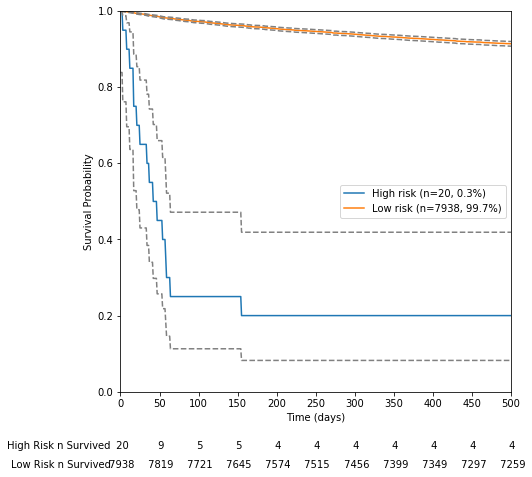

In [80]:
fig, axx = plt.subplots(1,1,figsize=(7,7))
thresh = 0.272073
res = plot_km(test, threshold=thresh, max_days=int(501), ax=axx, xticks=range(0,550,50))
fig.savefig('../figures/survival_RF_alert_rate0.02_threshold_0.272_500Day.pdf',
            format='pdf', bbox_inches='tight', pad_inches=0.5)

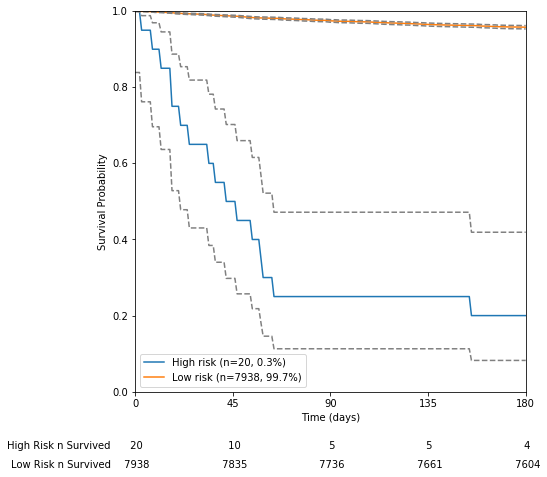

In [81]:
fig, axx = plt.subplots(1,1,figsize=(7,7))
thresh = 0.272073
plot_km(test, threshold=thresh, max_days=int(181), ax=axx)
fig.savefig('../figures/survival_RF_alert_rate0.02_threshold_0.272.pdf', format='pdf', bbox_inches='tight', pad_inches=0.5)

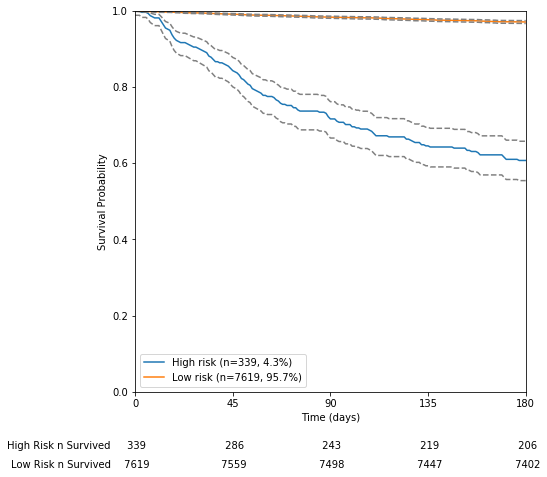

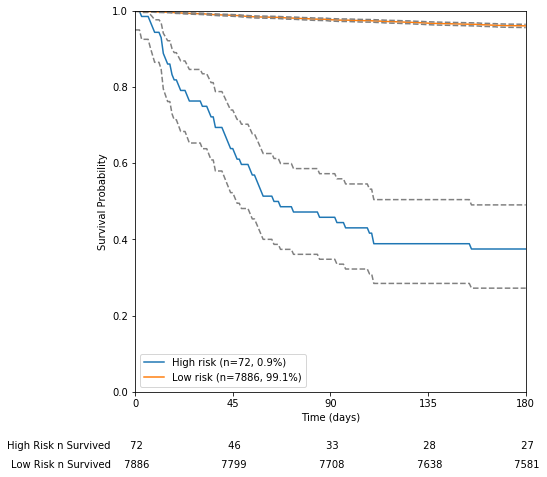

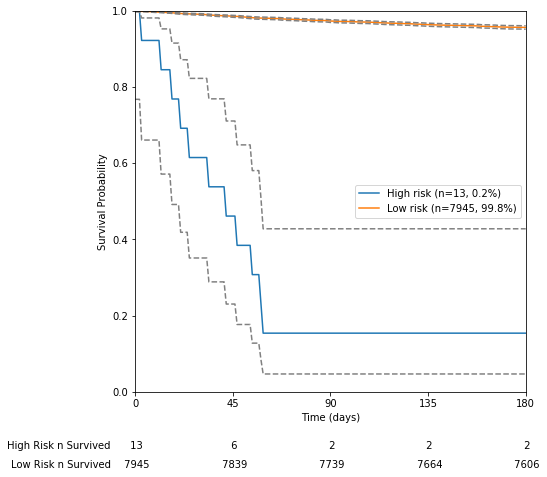

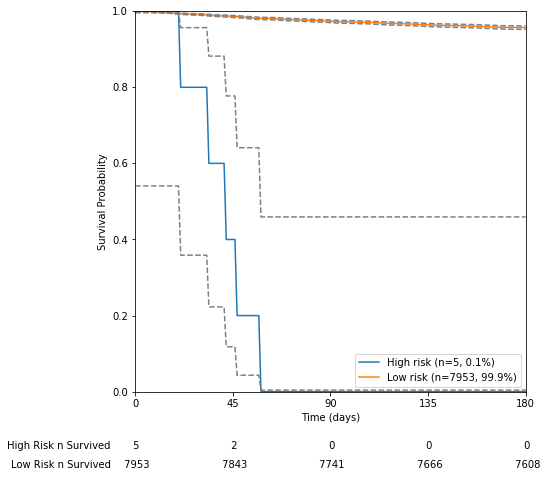

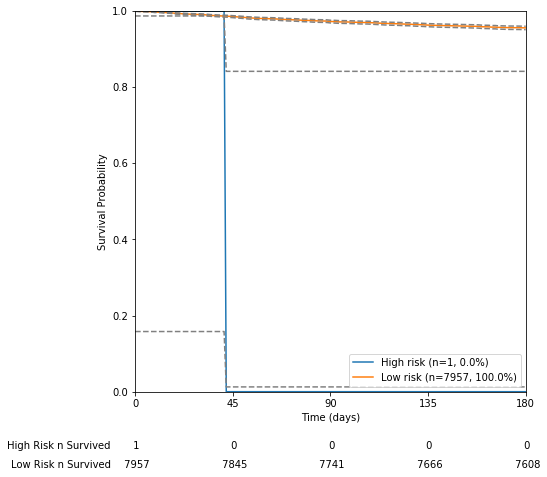

In [82]:
for i,thresh in enumerate([0.1,0.2,0.3,0.4,0.5]):
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    plot_km(test, threshold=thresh, max_days=int(181), ax=ax)
    fig.savefig('../figures/survival_RF_threshold_{}.pdf'.format(thresh), format='pdf', bbox_inches='tight', pad_inches=0.5)